In [3]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
#from matplotlib import pyplot as plt
import NAFFlib
from math import modf
#from scipy.constants import physical_constants
from matplotlib import pyplot as plt
from scipy.stats import linregress
import math

In [19]:
print(f"\n\nThis code compares the detuning effect of sextupoles (second order) and octupoles (first order) on N simulated particles\n\n")

#defining some functions to calculate sextupoles and octupoles strength

def oct_str(I_MO, tw, OCT_ON):
    if(OCT_ON == False):
        print("Octupole Strength is zero")
        return 0.0
    with open('hl_line.json', 'r') as fid:
        loaded_dct = json.load(fid)
        line = xt.Line.from_dict(loaded_dct)
    line.vars['i_mo'] = I_MO
    print(f'\n\nCalculating Octupolar strength with i_mo = {I_MO} A')
    alpha_xx = 0.0
    sum_nl_x = 0.0
    ii = 0
    for elem in line.element_dict :
        if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
            if(line.element_dict[elem].order==3):
                    sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]
        ii += 1
    m_x = (3*sum_nl_x)/(6*8*np.pi)
    #print(f'\n\nOctupolar angular Coefficient = {m_x}/m')
    return m_x

def sext_strength(nu_x, tw_normal, sext_name, sext_str, SEXT_ON, doit):
    if(Sextupoles_On == False):
        print("\n\nSextupole Strength is zero")
        return 0.0
    if(doit == False):
        print(f'\n\nUsing default Angular Coefficient')
        return 48993.18607814781
    print(f'\n\nCalculating Sextupolar strength')
    sext_df = pd.DataFrame(list(zip(sext_name, sext_str)), columns = ['Sextupole Name', 'Sextupole Strength'])
    tw_df = pd.DataFrame({'name':list(tw_normal['name']),'x':list(tw_normal['x']),'px':list(tw_normal['px']),'y':list(tw_normal['y']),
                         'py':list(tw_normal['py']),'zeta':list(tw_normal['zeta']),'delta':list(tw_normal['delta']),
                         'betx':list(tw_normal['betx']),'bety':list(tw_normal['bety']),'mux':list(tw_normal['mux']),'muy':list(tw_normal['muy'])})
    jj = 0
    l_name = []
    l_str = []
    l_betx = []
    l_bety = []
    l_mux = []
    l_muy = []
    for ii in range(len(tw_df['name'])):
        if(tw_df['name'][ii] == sext_df['Sextupole Name'][jj]):
            l_name.append(tw_df['name'][ii])
            l_str.append(sext_df['Sextupole Strength'][jj])
            l_betx.append(tw_df['betx'][ii])
            l_mux.append(tw_df['mux'][ii])
            l_bety.append(tw_df['bety'][ii])
            l_muy.append(tw_df['muy'][ii])
            jj += 1
            if(jj == 1628):
                break
    second_order_df = pd.DataFrame(list(zip(l_name, l_str, l_betx, l_bety, l_mux, l_muy)), 
                                   columns = ['Sextupole Name', 'Sextupole Strength', 'betx', 'bety', 'mux', 'muy'])
    alpha_xx= 0.0
    for ii in range(len(second_order_df['Sextupole Name'])):
        if(ii%100 == 0):
            print('Iteration number ', ii, 'of', len(second_order_df['Sextupole Name']))
        count = 0
        for jj in range(len(second_order_df['Sextupole Name'])):
            psi_ij_mod_x=np.abs(2*np.pi*second_order_df['mux'][ii]-2*np.pi*second_order_df['mux'][jj])
            beta_i_beta_j_x = pow(second_order_df['betx'][ii],3/2)*pow(second_order_df['betx'][jj],3/2)
            S_i_S_j = second_order_df['Sextupole Strength'][ii]*second_order_df['Sextupole Strength'][jj]
            I1_x = (np.cos(3*(np.pi*nu_x-psi_ij_mod_x)))/(np.sin(3*np.pi*nu_x))
            I2_x = 3*(np.cos(np.pi*nu_x-psi_ij_mod_x)/(np.sin(np.pi*nu_x)))
            alpha_xx += beta_i_beta_j_x*(S_i_S_j)*((I1_x)+(I2_x))
    alpha_xx_tot = -alpha_xx/(64*np.pi)    
    #print(f'\n\nSextupolar angular Coefficient = {alpha_xx_tot}/m')
    return alpha_xx_tot

    
    














#Parameters needed 
i_mo = -350 #Octupole current, Ampere, zero by default
p0c = 7000e9 #keV
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6 #m*rad
N_particles = 11 
N=1000 #Total number of turns
sampling= 1 #Sampling rate, 1 sample every 'sampling' turns

#The two linear coefficients we want to study
ang_coeff_sext = 0.0
ang_coeff_oct = 0.0

#You can decide to turn on one or both
Octupoles_On = True
Sextupoles_On = False
Sextupoles_Sum = False
#We need to save sextupole name and strength
sext_name = [] 
sext_str = []


if(Octupoles_On == False):
    i_mo = 0
    print(f"\n\nChanging Octupole Current from -350 A to i_mo = {i_mo} A\n\n")

print(f"\n\nOctupole Current is i_mo = {i_mo} A\n\n")
ctx_cpu = xo.ContextCpu() #Code is intended for CPU

#Opening the line

with open('hl_line.json', 'r') as fid:
        loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)

#Reference particle
particle_0 = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=p0c, x=1e-3, y=1e-3)

#Changing the octupole current via knob
line.vars['i_mo'] = i_mo

print(f'\n\nLoading the tracker\n\n')
tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
ref = tracker_normal.find_closed_orbit(particle_ref = particle_0) 
print(f'\n\nSanity check on closed orbit (CO), the values obtained by the tracker are\n\n')
print(f'\n\nCO.x = {ref.x}, CO.y = {ref.y}, CO.zeta = {ref.zeta} \n\n')

tw_normal = tracker_normal.twiss(ref)
betx_at_ip3 = tw_normal['betx'][0]
sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
tune_x = tw_normal['qx']
print(f'\n\nBeta values at ip3, betx = {betx_at_ip3} m')
print(f'\n\nSigma values, sigma_x = {sigma_x}')

ang_coeff_oct = oct_str(i_mo, tw_normal, Octupoles_On)
print(f'\n\nThe Octupolar angular Coefficient is = = {ang_coeff_oct}/m')


#----closed orbit particle----------
p0_normal = ref 
#----particles to track----------
particles_x = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                     x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#Saving the starting position
x0 = []
ii = 0
for ii in range(len(particles_x.x)):
    x0.append(particles_x.x[ii])

#------Sextupole section-------------
ii = 0
if(Sextupoles_On == False):
    print('\n\nTurning off Sextupoles')
for elem in line.element_dict :
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if((line.element_dict[elem].order==2) and (not Sextupoles_On) ):
            line.element_dict[elem].knl[2]=0
        if(line.element_dict[elem].order==2):
            sext_name.append(elem)
            sext_str.append(line.element_dict[elem].knl[2])
    ii+=1
ang_coeff_sext = sext_strength(tune_x, tw_normal, sext_name, sext_str, Sextupoles_On,Sextupoles_Sum)
print(f'\n\nThe Sextupolar angular Coefficient is = = {ang_coeff_sext}/m')

#-----tracking x direction------------------


my_result_x = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result_x[ii] = []


for ii in range(N):
    tracker_normal.track(particles_x, num_turns=sampling,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result_x[jj].append(getattr(particles_x,jj).copy())       
        
        
for jj in ['x','px','y','py','zeta','delta']:
        my_result_x[jj] = np.array(my_result_x[jj])



qx_part_x = []
qy_part_x = []

for ii in range(N_particles):  
    qx_part_x.append(NAFFlib.get_tune(my_result_x['x'][:,ii]))
    qy_part_x.append(NAFFlib.get_tune(my_result_x['y'][:,ii]))

jx = np.zeros(N_particles)
tg_phix = -tw_normal['alfx'][0]
phix = np.arctan(tg_phix)
for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3*np.cos(phix)*np.cos(phix))
    
slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[6]],[qx_part_x[0],qx_part_x[6]])
print(f'\n\nThe Simulated Angular Coefficient is {slope}/m')
print(f'\n\nTheoretical Calculation/Simulation = {(ang_coeff_sext+ang_coeff_oct)*100/(slope)}%')



This code compares the detuning effect of sextupoles (second order) and octupoles (first order) on N simulated particles




Octupole Current is i_mo = -350 A




Loading the tracker


generating ./9a779d697c8c4e329e975ac6b9e0990a.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/sim_stud/git_postprocessing'
running build_ext
building '9a779d697c8c4e329e975ac6b9e0990a' extension
gcc -pthread -B /home/afornara/py/2022_03_18/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_18/miniconda/include -I/home/afornara/py/2022_03_18/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_18/miniconda/include -fPIC -I/home/afornara/py/2022_03_18/miniconda/include/python3.9 -c 9a779d697c8c4e329e975ac6b9e0990a.c -o ./9a779d697c8c4e329e975ac6b9e0990a.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_18/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03

[2.09099412e-06 4.18198824e-06 6.27298236e-06 8.36397648e-06
 1.04549706e-05 1.25459647e-05 1.46369588e-05 1.67279530e-05
 1.88189471e-05 2.09099412e-05 2.30009353e-05]
m =  -537673.0749535396 q =  0.3100000982960055


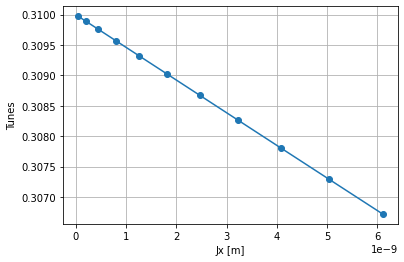

In [13]:
jx = np.zeros(N_particles)
tg_phix = -tw_normal['alfx'][0]
phix = np.arctan(tg_phix)
for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3*np.cos(phix)*np.cos(phix))
plt.plot(jx,qx_part_x,'-o');
plt.grid()
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[6]],[qx_part_x[0],qx_part_x[6]])
print('m = ',slope,'q = ',intercept)

In [10]:
48993.18509504592/49436.8417286188

0.9910257893089467

In [13]:
584122.3063146734/586544.98310883

0.9958695805710998

In [6]:
333784.17206337844+48993.18607814781


382777.35814152623

In [14]:
-584122.2820287822+48993.18607814781


-535129.0959506343

In [15]:
-535129.0959506343/-537673.0749535396

0.9952685393384723